Dans ce projet on s'attaque au problème de classification de document. Pour cela on a choisi des données issus d'articles de la BBC (https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification) classifié en 5 catégorie : business, divertissement, sport, tech, politique. On propose dans un premier temps quelques statistique descriptives pour mieux comprendre notre jeu de données puis on explore deux méthodes de classification. Une première, plus usuelle, via un embedding Doc2Vec et en utilisant des réseaux de neurones. Et une seconde, plus originale, en regardant notre corpus de document comme un graphe bipartie mots-documents et en clusterant via la méthode spectrale decrite dans https://www.cs.utexas.edu/users/inderjit/public_papers/kdd_bipartite.pdf . Chaque partie du notebook qui suit peut s'exécuter indépendamment.


# Statistiques descriptives

In [ ]:
#Importation des données du drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import pandas as pd
import string

In [ ]:
#Importation specifique de chaque dossier d'article (business, entertainment, politics, sport, tech) + construction des différentes liste de mots

lbus=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/business").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  lbus.append(tokenized)

lent=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/entertainment").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  lent.append(tokenized)

lpol=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/politics").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  lpol.append(tokenized)

lspo=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/sport").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  lspo.append(tokenized)

ltech=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/tech").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  ltech.append(tokenized)

l=lbus+lent+lpol+lspo+ltech

In [ ]:
#longeur moyenne des articles par classe
def avgdoclentgh(l):
  k=0
  for x in l:
    k=k+len(x)
  return(k/len(l))
    
print(avgdoclentgh(lbus), avgdoclentgh(lent), avgdoclentgh(lpol), avgdoclentgh(lspo), avgdoclentgh(ltech), avgdoclentgh(l))

327.1764705882353 328.81088082901556 452.052757793765 328.0078431372549 501.286783042394 382.4581834532374


On regarde l'occurence des mots dans chaque classe, on remarque qu'une fois les mots "usuels" (article, pronom, connecteur logique, verbe commun,...), se détache dans chaque classe un vocabulaire qui lui est propre.

In [ ]:
from collections import Counter

In [ ]:
print(Counter(lbus).most_common())

[('the', 10817), ('to', 5068), ('of', 4379), ('in', 4324), ('a', 3414), ('and', 3202), ('said', 1680), ('is', 1608), ('for', 1605), ('that', 1584), ('it', 1414), ('on', 1365), ('has', 1252), ('its', 1155), ('by', 1095), ('as', 931), ('at', 925), ('was', 916), ('with', 906), ('be', 871), ('from', 857), ('have', 828), ('are', 809), ('us', 801), ('will', 788), ('year', 610), ('mr', 600), ('but', 590), ('which', 586), ('an', 575), ('this', 502), ('had', 489), ('not', 473), ('would', 463), ('more', 462), ('been', 458), ('than', 456), ('he', 450), ('also', 440), ('were', 436), ('up', 430), ('market', 420), ('new', 416), ('growth', 384), ('their', 371), ('company', 366), ('last', 365), ('about', 362), ('economy', 352), ('we', 332), ('firm', 321), ('sales', 316), ('bank', 316), ('after', 316), ('could', 311), ('economic', 310), ('they', 307), ('2004', 305), ('government', 298), ('oil', 294), ('over', 282), ('years', 274), ('shares', 265), ('however', 256), ('may', 248), ('prices', 246), ('one'

In [ ]:
print(Counter(lent).most_common())

[('the', 8262), ('and', 3010), ('of', 2967), ('to', 2897), ('in', 2802), ('a', 2735), ('for', 1543), ('on', 1173), ('was', 1140), ('is', 1082), ('with', 946), ('it', 871), ('at', 835), ('said', 825), ('he', 804), ('that', 748), ('film', 732), ('as', 705), ('has', 695), ('be', 679), ('his', 670), ('by', 665), ('best', 590), ('will', 577), ('have', 572), ('from', 512), ('but', 508), ('who', 502), ('i', 488), ('its', 466), ('are', 464), ('which', 451), ('music', 430), ('an', 424), ('this', 404), ('also', 398), ('had', 392), ('not', 384), ('been', 379), ('were', 367), ('us', 367), ('one', 354), ('they', 335), ('years', 335), ('she', 332), ('new', 322), ('her', 314), ('show', 308), ('their', 304), ('we', 289), ('up', 274), ('awards', 273), ('after', 263), ('year', 259), ('last', 252), ('first', 251), ('more', 245), ('all', 236), ('award', 233), ('number', 227), ('won', 225), ('about', 223), ('out', 213), ('uk', 211), ('two', 209), ('films', 209), ('director', 206), ('tv', 205), ('than', 203

In [ ]:
print(Counter(lpol).most_common())

[('the', 12178), ('to', 5994), ('of', 4467), ('and', 3968), ('a', 3898), ('in', 3386), ('said', 2240), ('he', 2200), ('for', 1919), ('that', 1909), ('on', 1853), ('is', 1836), ('mr', 1686), ('be', 1672), ('was', 1576), ('it', 1452), ('as', 1096), ('not', 1067), ('but', 1053), ('have', 1052), ('would', 1051), ('with', 1024), ('by', 1010), ('are', 995), ('will', 982), ('has', 958), ('his', 856), ('they', 842), ('at', 839), ('had', 758), ('from', 732), ('we', 724), ('this', 673), ('i', 665), ('government', 644), ('an', 643), ('were', 628), ('labour', 616), ('people', 593), ('been', 581), ('election', 565), ('there', 549), ('their', 545), ('who', 532), ('which', 518), ('blair', 509), ('party', 480), ('more', 476), ('also', 452), ('about', 452), ('if', 448), ('new', 430), ('its', 408), ('minister', 393), ('up', 386), ('could', 384), ('or', 378), ('should', 371), ('all', 366), ('told', 359), ('over', 340), ('what', 338), ('out', 338), ('after', 331), ('brown', 327), ('public', 321), ('plans'

In [ ]:
print(Counter(lspo).most_common())

[('the', 9629), ('to', 4693), ('a', 3842), ('and', 3667), ('in', 3644), ('of', 2798), ('for', 1744), ('i', 1631), ('he', 1625), ('on', 1501), ('is', 1488), ('but', 1448), ('was', 1418), ('that', 1214), ('with', 1207), ('it', 1189), ('at', 1171), ('have', 1150), ('his', 1143), ('has', 966), ('be', 963), ('said', 940), ('we', 920), ('will', 900), ('as', 832), ('not', 713), ('from', 687), ('after', 655), ('had', 609), ('by', 591), ('been', 556), ('are', 554), ('they', 534), ('an', 518), ('this', 510), ('who', 504), ('their', 504), ('game', 473), ('out', 472), ('against', 454), ('first', 435), ('when', 419), ('win', 415), ('would', 396), ('england', 394), ('all', 393), ('if', 390), ('over', 386), ('last', 375), ('world', 373), ('were', 372), ('there', 370), ('up', 365), ('you', 359), ('one', 354), ('two', 351), ('its', 342), ('also', 329), ('time', 327), ('my', 323), ('back', 318), ('she', 311), ('players', 309), ('can', 305), ('before', 301), ('her', 299), ('play', 292), ('cup', 290), ('h

In [ ]:
print(Counter(ltech).most_common())

[('the', 11695), ('to', 6336), ('of', 5350), ('and', 4715), ('a', 4345), ('in', 3465), ('that', 2593), ('is', 2536), ('for', 2101), ('it', 2073), ('on', 1639), ('be', 1614), ('are', 1576), ('said', 1567), ('as', 1413), ('with', 1258), ('will', 1225), ('have', 1143), ('by', 1127), ('has', 1080), ('was', 970), ('they', 958), ('people', 940), ('more', 938), ('at', 846), ('not', 837), ('but', 820), ('its', 781), ('which', 777), ('this', 754), ('can', 744), ('from', 743), ('he', 700), ('or', 688), ('their', 679), ('an', 650), ('about', 544), ('you', 539), ('than', 538), ('also', 537), ('up', 533), ('were', 528), ('new', 517), ('mr', 509), ('technology', 504), ('been', 497), ('one', 496), ('would', 471), ('could', 469), ('mobile', 466), ('we', 444), ('games', 417), ('users', 414), ('other', 398), ('out', 398), ('there', 398), ('music', 384), ('use', 379), ('such', 377), ('digital', 373), ('software', 371), ('all', 370), ('us', 363), ('i', 357), ('some', 357), ('many', 356), ('them', 346), ('

In [ ]:
print(Counter(l).most_common())

[('the', 52581), ('to', 24988), ('of', 19961), ('and', 18562), ('a', 18234), ('in', 17621), ('for', 8912), ('is', 8550), ('that', 8048), ('on', 7531), ('said', 7252), ('it', 6999), ('was', 6020), ('be', 5799), ('he', 5779), ('with', 5341), ('as', 4977), ('has', 4951), ('have', 4745), ('at', 4616), ('by', 4488), ('will', 4472), ('but', 4419), ('are', 4398), ('from', 3531), ('not', 3474), ('i', 3259), ('its', 3152), ('his', 3019), ('mr', 3004), ('they', 2976), ('this', 2843), ('an', 2810), ('we', 2709), ('which', 2584), ('had', 2579), ('would', 2577), ('been', 2471), ('their', 2403), ('more', 2335), ('were', 2331), ('also', 2156), ('who', 2072), ('up', 1988), ('new', 1970), ('people', 1969), ('us', 1907), ('about', 1801), ('one', 1739), ('there', 1732), ('after', 1672), ('or', 1626), ('out', 1624), ('year', 1607), ('than', 1604), ('can', 1534), ('all', 1525), ('if', 1518), ('could', 1509), ('over', 1430), ('you', 1426), ('last', 1380), ('when', 1342), ('first', 1280), ('years', 1223), ('

On regarde également les bigrams, même constat, après les pairs de mots usuel semblent se détacher des pairs de mots spécifique et propre à chaque classe.

In [ ]:
import nltk

def Bigram(L):
  lst=[]
  for x in l:
    lst=lst+list(nltk.bigrams(x))
  return(Counter(lst).most_common())

In [ ]:
print(Bigram(lbus)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

In [ ]:
print(Bigram(lent)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

In [ ]:
print(Bigram(lpol)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

In [ ]:
print(Bigram(lspo)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

In [ ]:
print(Bigram(ltech)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

In [ ]:
print(Bigram(l)[:1000])

[(('of', 'the'), 4945), (('in', 'the'), 4911), (('to', 'the'), 2045), (('for', 'the'), 1877), (('on', 'the'), 1798), (('to', 'be'), 1709), (('at', 'the'), 1599), (('and', 'the'), 1338), (('he', 'said'), 1322), (('will', 'be'), 1236), (('said', 'the'), 1197), (('it', 'is'), 1172), (('in', 'a'), 1070), (('that', 'the'), 1008), (('with', 'the'), 996), (('by', 'the'), 960), (('has', 'been'), 902), (('it', 'was'), 883), (('from', 'the'), 835), (('of', 'a'), 798), (('the', 'us'), 796), (('is', 'a'), 724), (('as', 'a'), 707), (('would', 'be'), 687), (('the', 'first'), 684), (('have', 'been'), 659), (('more', 'than'), 650), (('with', 'a'), 598), (('one', 'of'), 589), (('for', 'a'), 588), (('the', 'uk'), 577), (('to', 'a'), 571), (('said', 'it'), 560), (('as', 'the'), 542), (('is', 'the'), 523), (('such', 'as'), 521), (('the', 'world'), 501), (('but', 'the'), 500), (('he', 'was'), 500), (('have', 'to'), 485), (('over', 'the'), 483), (('to', 'make'), 475), (('the', 'government'), 473), (('was', 

# Embedding Doc2Vec


Dans cette partie on propose dans un premier temps un embedding de nos données via Doc2Vec (https://radimrehurek.com/gensim/models/doc2vec.html), on entraine ensuite sur les données vectorisées, une regression logistique puis un réseau de neuronnes.

In [ ]:
#Importation des données du drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import pandas as pd
import string
import numpy as np

In [ ]:
#importation/structuration des données
from gensim.models.doc2vec import TaggedDocument

docs_train=[]
l_train=[]
c_train=[]
docs_test=[]
l_test=[]
c_test=[]

k=0

pathlist = Path("/content/drive/MyDrive/Text classification bbc/business").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  if k%2==0:
    docs_train.append(TaggedDocument(words=tokenized, tags=['bus']))
    l_train.append(tokenized)
    c_train.append('bus')
  else:
    docs_test.append(TaggedDocument(words=tokenized, tags=['bus']))
    l_test.append(tokenized)
    c_test.append('bus')
  k=k+1

pathlist = Path("/content/drive/MyDrive/Text classification bbc/entertainment").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  if k%2==0:
    docs_train.append(TaggedDocument(words=tokenized, tags=['ent']))
    l_train.append(tokenized)
    c_train.append('ent')
  else:
    docs_test.append(TaggedDocument(words=tokenized, tags=['ent']))
    l_test.append(tokenized)
    c_test.append('ent')
  k=k+1


pathlist = Path("/content/drive/MyDrive/Text classification bbc/politics").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  if k%2==0:
    docs_train.append(TaggedDocument(words=tokenized, tags=['pol']))
    l_train.append(tokenized)
    c_train.append('pol')
  else:
    docs_test.append(TaggedDocument(words=tokenized, tags=['pol']))
    l_test.append(tokenized)
    c_test.append('pol')
  k=k+1


pathlist = Path("/content/drive/MyDrive/Text classification bbc/sport").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  if k%2==0:
    docs_train.append(TaggedDocument(words=tokenized, tags=['spo']))
    l_train.append(tokenized)
    c_train.append('spo')
  else:
    docs_test.append(TaggedDocument(words=tokenized, tags=['spo']))
    l_test.append(tokenized)
    c_test.append('spo')
  k=k+1


pathlist = Path("/content/drive/MyDrive/Text classification bbc/tech").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  if k%2==0:
    docs_train.append(TaggedDocument(words=tokenized, tags=['tech']))
    l_train.append(tokenized)
    c_train.append('tech')
  else:
    docs_test.append(TaggedDocument(words=tokenized, tags=['tech']))
    l_test.append(tokenized)
    c_test.append('tech')
  k=k+1


In [ ]:
#entrainement Doc2Vec
from gensim import models
model = models.Doc2Vec(vector_size=300, window=5, min_count=5, workers=4, epochs=20)
model.build_vocab(docs_train)
model.train(docs_train, total_examples=model.corpus_count, epochs=model.iter)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


In [ ]:
#vectorisation des données
vectorized_train=[]
for x in l_train:
  vectorized_train.append(model.infer_vector(x))

vectorized_test=[]
for x in l_test:
  vectorized_test.append(model.infer_vector(x))

In [ ]:
df_train=pd.concat((pd.DataFrame(np.array(vectorized_train)),pd.DataFrame(c_train)), axis=1)
df_test=pd.concat((pd.DataFrame(np.array(vectorized_test)),pd.DataFrame(c_test)), axis=1)

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,0
0,-0.307598,0.408353,-0.477894,0.291070,-0.033387,0.555621,-0.362237,0.585983,-0.584517,-0.758378,...,-0.089212,0.671832,0.372686,0.320155,0.021421,1.787312,-1.119559,-0.059702,-1.348991,bus
1,0.275858,1.069869,-1.085225,0.360675,-0.172656,0.098050,-0.892649,0.575291,-0.170076,-1.245271,...,0.535848,0.328754,0.590307,0.548669,-0.037496,0.878251,-0.599584,0.341516,-0.923044,bus
2,-0.200939,-0.147748,-0.225325,0.426355,-0.942846,0.162018,-1.090911,0.982577,-0.087317,-1.265241,...,0.472934,0.340999,0.165073,0.257910,0.078065,1.619304,-0.459172,-0.127353,-0.656446,bus
3,-0.425542,1.094327,-0.874931,0.275422,-0.419764,-0.260915,-0.272762,0.217714,-0.455065,-0.870758,...,0.639362,0.159736,0.782411,0.711549,0.058079,0.392953,-0.704139,0.124681,-1.088742,bus
4,0.006734,0.943481,-0.739097,0.540409,0.070797,-0.224170,-0.623941,0.313914,-0.473817,-0.793503,...,0.138920,0.180822,0.438841,0.583888,-0.498111,0.840160,-0.642133,-0.151842,-0.742946,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,0.611038,1.339674,-1.905638,0.411144,-1.031755,0.271939,-0.918294,1.105167,0.414677,0.861274,...,0.723684,0.850148,1.023310,0.595352,-0.240874,1.382606,-1.281525,-0.467796,-0.249394,tech
1108,1.228692,1.906575,-1.676958,-0.438399,-1.895370,0.570604,-1.407258,0.675606,0.323318,0.975286,...,0.555189,1.322074,2.258254,1.585072,-0.623999,0.756747,-1.458994,-0.074300,-0.858631,tech
1109,0.807452,1.396981,-1.339904,-0.046537,-0.765924,0.397289,-0.886270,0.788022,-0.102661,0.386713,...,0.769780,0.967450,0.654845,0.839356,-0.375441,1.112326,-1.009997,0.188400,-0.701127,tech
1110,1.174296,2.646131,-1.785316,-0.073357,-0.647918,0.360594,-0.227542,0.738801,-0.424472,0.389884,...,1.207587,0.785590,1.088781,0.946232,-0.724625,0.404050,-0.957971,-0.121312,-0.858048,tech


In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,0
0,0.149726,0.734759,-0.603269,0.267822,-0.569384,-0.027161,-0.695256,0.403544,-0.225629,-0.455809,...,0.139429,0.264614,0.284317,0.370727,0.068934,0.915485,-0.805859,0.245397,-0.455225,bus
1,0.469648,0.875414,-0.750299,0.217198,-0.232603,0.035626,-0.580980,0.346362,-0.327989,-0.544647,...,0.607023,0.308532,0.098704,0.769998,-0.411258,0.637942,-0.399631,0.203233,-0.451322,bus
2,0.635697,0.337336,-0.706306,-0.333291,-0.745497,0.482698,-1.157322,1.320819,-0.177856,-0.490513,...,0.303677,0.157865,0.307507,0.546734,-0.262990,1.265129,-0.505187,0.317022,-0.653331,bus
3,0.156917,0.409835,-0.071511,0.031864,-0.386535,-0.205389,-0.866508,0.438390,0.105401,-0.746614,...,0.139497,0.102699,0.396949,0.472817,-0.295852,0.855739,-0.404499,0.340806,-0.909702,bus
4,0.076740,0.683302,-0.846025,0.225752,-0.586166,0.301679,-0.768749,0.290337,0.120582,-0.046805,...,0.267757,0.445343,0.488313,0.172603,0.026122,0.524768,-0.329503,0.081522,-0.788687,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1.351830,1.658488,-1.355771,-0.175940,-1.304705,0.008745,-1.321958,0.881107,-0.379066,-0.261922,...,0.587913,0.629969,1.556675,1.399277,-0.199412,0.431416,-0.984413,0.184113,-0.573783,tech
1108,0.458183,1.055426,-0.870022,-0.025506,-0.358072,-0.807331,-0.015009,0.656628,0.088935,-0.145494,...,0.982199,1.340414,0.283381,0.756923,-0.274914,0.627808,-0.599891,0.331007,0.105859,tech
1109,0.508538,1.108273,-1.285353,-0.110745,-0.430822,-0.353714,-0.543493,0.597355,0.179026,0.206197,...,0.715369,0.796399,0.789642,0.518054,-0.276781,0.575027,-0.595492,-0.082653,-0.460973,tech
1110,1.112895,1.601260,-0.841004,-0.223567,-0.832906,-0.311487,-1.031631,0.594480,0.263285,0.132201,...,1.031555,0.763293,0.550409,0.983689,-0.690273,0.165917,-1.118196,0.680812,-0.508389,tech


In [ ]:
#entrainement de la regression logistique sur les données vectorisées
from sklearn.linear_model import LogisticRegression
modele_logit = LogisticRegression(penalty='none',solver='newton-cg')
modele_logit.fit(vectorized_train,c_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
#Score train (pourcentage de mal classifié (loss 0-1 normalisée))
pred_train=modele_logit.predict(vectorized_train)
k=0
for i in range(len(c_train)):
  if pred_train[i]!=c_train[i]:
    k=k+1
print(k/len(c_train))

0.0


In [ ]:
#Score test (pourcentage de mal classifié (loss 0-1 normalisée))
pred_test=modele_logit.predict(vectorized_test)
k=0
for i in range(len(c_test)):
  if pred_test[i]!=c_test[i]:
    k=k+1
print(k/len(c_test))


0.03597122302158273


In [ ]:
#transformation des label en one-hot (preprocessing NN)
one_hot_train=[]
for x in c_train:
  if x=='bus':
    one_hot_train.append([1,0,0,0,0])
  if x=='ent':
    one_hot_train.append([0,1,0,0,0])
  if x=='pol':
    one_hot_train.append([0,0,1,0,0])
  if x=='spo': 
    one_hot_train.append([0,0,0,1,0])
  if x=='tech':
    one_hot_train.append([0,0,0,0,1])

one_hot_test=[]
for x in c_test:
  if x=='bus':
    one_hot_test.append([1,0,0,0,0])
  if x=='ent':
    one_hot_test.append([0,1,0,0,0])
  if x=='pol':
    one_hot_test.append([0,0,1,0,0])
  if x=='spo': 
    one_hot_test.append([0,0,0,1,0])
  if x=='tech':
    one_hot_test.append([0,0,0,0,1])

In [ ]:
import torch
import torch.nn as nn
import random
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
from posixpath import normpath
## definition  et entrainement du réseau
model_nn= nn.Sequential(
    nn.Linear(300, 1000),
    nn.PReLU(),
    nn.Linear(1000, 1000),
    nn.PReLU(),
    nn.Linear(1000, 100),
    nn.PReLU(),
    nn.Linear(100, 5)
)
optim = torch.optim.Adam(model_nn.parameters(), lr=1e-3)
lossFn = nn.MSELoss()
n_steps = 100
mini_batch = 100
trainLosses = []
testLosses = []

for i in range(n_steps):
  indexes = random.choices(range(len(vectorized_train)), k=mini_batch)
  x_sample, y_sample = np.array(vectorized_train)[indexes], np.array(one_hot_train)[indexes]

  x_sample = torch.tensor(x_sample.astype(np.float32), device=device, dtype=torch.float)
  y = model_nn(x_sample)
  loss = lossFn(y.squeeze(1), torch.tensor(y_sample.astype(np.float32), device=device, dtype=torch.float))
  trainLosses.append(float(loss))

  loss.backward()
  optim.step()
  model_nn.zero_grad()
  with torch.no_grad():
    testLosses.append(float(lossFn(model_nn(torch.tensor(np.array(vectorized_test).astype(np.float32), device=device, dtype=torch.float)).squeeze(1), torch.tensor(np.array(one_hot_test), device=device, dtype=torch.float))))

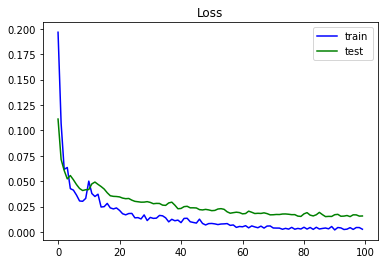

In [ ]:
#Score train et test (Loss L2)
import matplotlib.pyplot as plt
plt.plot(range(n_steps), trainLosses, color="blue", label='train')
plt.plot(range(n_steps), testLosses, color="green", label='test')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
testLosses[-1]

0.015743691474199295

In [ ]:
#prediction test (plus grand coef)
pred_t=model_nn(torch.tensor(np.array(vectorized_test).astype(np.float32), device=device, dtype=torch.float)).detach().numpy()
pred=[]
for x in pred_t:
  temp=[0,0,0,0,0]
  loc = np.where(x == np.amax(x))[0][0]
  temp[loc]=1
  pred.append(temp)

print(pred)

[[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 

In [ ]:
#Score test (pourcentage de mal classifié (loss 0-1 normalisée)), mieux que la regression logistique
k=0
for j in range(len(one_hot_test)):
  if (np.array(one_hot_test)[j]-np.array(pred)[j]).any()!=np.array([0,0,0,0,0]).any():
    k=k+1
print(k/len(one_hot_test))

0.02877697841726619


# Co-clustering mots-documents via la méthode spectral pour les graphes biparties.

On présente briévement l'article de Inderjit S. Dhillon, "Co-clustering documents and words using Bipartite
Spectral Graph Partitioning", qui s'intéresse au problème de clustering simultanée de mots et de documents.

Pour cela, on peut répresenter notre corpus de documents et les mots contenus dans ces documents par un graphe bipartie. On note ce graphe $G=(V,E)$, avec  et l'ensemble des arrêtes $E$ et l'ensemble des sommets $V=W\cup D$, $D$ l'ensemble des documents et $W$ l'ensemble des mots contenus dans les documents de $W$. Dans ce graphe on ne considère que les arrêtes entre mots et documents (i.e pas d'arrête entre deux mots, ou entre deux documents). Il y a une arrêtes entre un documents $i$ et un mot $j$ si $j$ apparaît dans $i$. On pondère également cette arrêtte par $E_{i,j}$ correspondant le nombre d'occurence de $i$ dans $j$. Toute ces information sont résumé dans la matrice d'adjacence $M$ de $G$ :  

$$M_{i j}= \begin{cases}E_{i j}, & \text { si il existe une arrête }\{i, j\} \\ 0, & \text { sinon. }\end{cases}$$

Un objet essentiel lorsque l'on s'intéresse au problème de clustering dans les graphes est celle de "cut", que  l'on definit ici pour deux cluster $\mathcal{V}_{1}, \mathcal{V}_{2}$ :

$$\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}\right)=\sum_{i \in \mathcal{V}_{1}, j \in \mathcal{V}_{2}} M_{i j}$$

et que l'on peut étendre sans problème pour $k$ cluster :  

$$\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}, \ldots, \mathcal{V}_{k}\right)=\sum_{i<j} \operatorname{cut}\left(\mathcal{V}_{i}, \mathcal{V}_{j}\right)$$

L'idée de la bipartition du graphe $G$ est alors de minimiser pour une fonction de poids donnée la quantité suivante :

$$\frac{\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}\right)}{\operatorname{weight}\left(\mathcal{V}_{1}\right)}+\frac{\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}\right)}{\operatorname{weight}\left(\mathcal{V}_{2}\right)}$$

On introduit alors la matrice Laplacienne $L$ de $G$ definit par :

$$L_{i j}= \begin{cases}\sum_{k} E_{i k}, & i=j \\ -E_{i j}, & i \neq j \text { si il existe une arrête }\{i, j\} \\ 0 & \text { sinon. }\end{cases}$$

On introduit également, La matrice de poids $W$, diagonale, contenant le poids de chaque arrêtes ( i.e pour une arrête $a$, on a $W_{a,a}=\operatorname{weight}(a)$) et le vecteur de partition $q$ donné par :

$$q_{i}= \begin{cases}+\sqrt{\frac{\eta_{2}}{\eta_{1}}}, & i \in \mathcal{V}_{1} \\ -\sqrt{\frac{\eta_{1}}{\eta_{2}}}, & i \in \mathcal{V}_{2}\end{cases}$$

On remarque alors que l'on peut écrire :

---

**Theorème 1**

$$\frac{\boldsymbol{q}^{T} \boldsymbol{L} \boldsymbol{q}}{\boldsymbol{q}^{T} \boldsymbol{W} \boldsymbol{q}}=\frac{\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}\right)}{\operatorname{weight}\left(\mathcal{V}_{1}\right)}+\frac{\operatorname{cut}\left(\mathcal{V}_{1}, \mathcal{V}_{2}\right)}{\operatorname{weight}\left(\mathcal{V}_{2}\right)}$$

---

Le problème de minimisation se reformule alors en minimiser $\frac{\boldsymbol{q}^{T} \boldsymbol{L} \boldsymbol{q}}{\boldsymbol{q}^{T} \boldsymbol{W} \boldsymbol{q}}$ pour un $q$ vecteur de partition (i.e de la forme definit ci-dessus). Or ce problème est connu pour être difficiel (NP-complet). On s'intèresse donc au problème relaxé suivant :

$$\min _{\boldsymbol{q} \neq \mathbf{0}} \frac{\boldsymbol{q}^{T} \boldsymbol{L} \boldsymbol{q}}{\boldsymbol{q}^{T} \boldsymbol{W} \boldsymbol{q}},  \boldsymbol{q}^{T} \boldsymbol{W} \boldsymbol{e}=0 $$

On remarque que pour $q$ vecteur de partition on a bien $\boldsymbol{q}^{T} \boldsymbol{W} \boldsymbol{e}=\sqrt{\frac{\eta_{2}}{\eta_{1}}} \sum_{i \in \mathcal{V}_{1}}$ weight $(i)-\sqrt{\frac{\eta_{1}}{\eta_{2}}} \sum_{i \in \mathcal{V}_{2}} \operatorname{weight}(i)=0$.

---

**Thèorème 2** 
 
Le problème relaxé est résolu en prenant $q$ le vecteur propre associée à la seconde plus petite valeur propre du problème des valeurs propres généralisés $L z=\lambda W z$. 

---

Le choix de la fonction de poids est sujet intéressant, le choix le plus simple etant de mettre un poids $1$ sur chaque arrêtes (i.e $\operatorname{weight}(a)=1$, pour toute arrrête $a$). Dans ce cas $W=D$, avec $D$ la matrice diagonal de dégré du graphe $G$.
En ecrivant $L$ sous la forme :

$$L=\left[\begin{array}{cc}D_{1} & -A \\ -A^{T} & D_{2}\end{array}\right]$$ 

On remarque que :

$$W=D=\left[\begin{array}{cc}D_{1} & 0 \\ 0 & D_{2}\end{array}\right]$$

Et le problème des valeurs propres généralisés s'ecrit alors :

$$\left[\begin{array}{cc}D_{1} & -A \\ -A^{T} & D_{2}\end{array}\right]\left[\begin{array}{l}x \\ y\end{array}\right]=\lambda\left[\begin{array}{cc}D_{1} & 0 \\ 0 & D_{2}\end{array}\right]\left[\begin{array}{l}x \\ y\end{array}\right]$$

En notant $\boldsymbol{u}=\boldsymbol{D}_{1}{ }^{1 / 2} \boldsymbol{x}$ et $\boldsymbol{v}=\boldsymbol{D}_{2}{ }^{1 / 2} \boldsymbol{y}$ on obtient que :
$$
\begin{aligned}
\boldsymbol{D}_{1}^{-1 / 2} \boldsymbol{A} \boldsymbol{D}_{2}^{-1 / 2} v &=(1-\lambda) \boldsymbol{u} \\
\boldsymbol{D}_{2}^{-1 / 2} \boldsymbol{A}^{T} \boldsymbol{D}_{1}{ }^{-1 / 2} \boldsymbol{u} &=(1-\lambda) \boldsymbol{v} .
\end{aligned}
$$
Donc $u$ et $v$ sont des vecteur singulier respcitivement à gauche et à droite de $A_{n}=\boldsymbol{D}_{1}^{-1 / 2} \boldsymbol{A} \boldsymbol{D}_{2}^{-1 / 2}$ de valeur singulière associée $1-\lambda$. Il suffit donc de calculer les vecteurs singulier à droite et à gauche, $v_2$ et $u_2$, de $A_n$ correspondant à sa deuxième plus grande valeur singulière. On construit ainsi $z_{2}=\left[\begin{array}{l}
D_{1}^{-1 / 2} u_{2} \\
D_{2}^{-1 / 2} v_{2}
\end{array}\right]$ le vecteur propre associée à la seconde plus petite valeur propre du problème des valeurs propres généralisés. Une manière d'approximer le clustering optimale est alors de minimiser sur $m$ bi-modale :

$$\sum_{j=1}^{2} \sum_{z_{2}(i) \in m_{j}}\left(z_{2}(i)-m_{j}\right)^{2}$$

Ce qui correspond exactement au k-means. On en déduit l'algorithme de bipartion suivant :

Algorithme de Bipartition
1. Sachant $\boldsymbol{A}$, $\boldsymbol{D_1}$, $\boldsymbol{D_2}$ construire $\boldsymbol{A}_{n}=\boldsymbol{D}_{1}^{-1 / 2} \boldsymbol{A D}_{2}^{-1 / 2}$.
2. Calculer la secondes valeurs singulière de $A_{n}$, et les vecteurs singuliers associées $u_{2}$ et $v_{2}$ puis construire $z_{2}=\left[\begin{array}{l}
D_{1}^{-1 / 2} u_{2} \\
D_{2}^{-1 / 2} v_{2}
\end{array}\right]$
3. Appliquer un algorithme de $k$-means sur $z_{2}$.

Cette algorithme se généralise aisément pour la multipartion :

Algorithme de Multipartition
1. Sachant $A$, construire $A_{n}=D_{1}{ }^{-1 / 2} A D_{2}^{-1 / 2}$.
2. Calculer $\ell=\left\lceil\log _{2} k\right\rceil$ vecteurs singuliers de $\boldsymbol{A}_{\boldsymbol{n}}, \boldsymbol{u}_{2}, \ldots \boldsymbol{u}_{\ell+1}$ et $\boldsymbol{v}_{2}, \ldots \boldsymbol{v}_{\ell+1}$, et construire $\boldsymbol{Z}=\left[\begin{array}{l}
\boldsymbol{D}_{1}^{-1 / 2} \boldsymbol{U} \\
\boldsymbol{D}_{2}^{-1 / 2} \boldsymbol{V}
\end{array}\right]$, $\boldsymbol{U}=\left[\boldsymbol{u}_{2}, \ldots, \boldsymbol{u}_{\ell+1}\right], \text { et } \boldsymbol{V}=\left[\boldsymbol{v}_{2}, \ldots, \boldsymbol{v}_{\ell+1}\right]$.
3. Appliquer les $k$-means à $Z$.

In [ ]:
#Importation des données du drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import pandas as pd
import string

In [ ]:
#Importation specifique de chaque dossier d'article (business, entertainment, politics, sport, tech) + construction des différentes liste de mots
#limitiation à deux classes (pas assez de RAM)

lbus=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/business").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  lbus=lbus+tokenized

lent=[]
#pathlist = Path("/content/drive/MyDrive/Text classification bbc/entertainment").glob('**/*.txt')
#for path in pathlist:
 # file = open(path)
  #tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  #file.close()
  #lent=lent+tokenized

lpol=[]
#pathlist = Path("/content/drive/MyDrive/Text classification bbc/politics").glob('**/*.txt')
#for path in pathlist:
  #file = open(path)
  #tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  #file.close()
  #lpol=lpol+tokenized

lspo=[]
#pathlist = Path("/content/drive/MyDrive/Text classification bbc/sport").glob('**/*.txt')
#for path in pathlist:
  #file = open(path)
  #tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  #file.close()
  #lspo=lspo+tokenized

ltech=[]
pathlist = Path("/content/drive/MyDrive/Text classification bbc/tech").glob('**/*.txt')
for path in pathlist:
  file = open(path)
  tokenized = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
  file.close()
  ltech=ltech+tokenized

In [ ]:
#Construction du dictionnaire contenant l'ensemble des mots (compté une sule fois) du corpus d'article 
l=lbus+lent+lpol+lspo+ltech
k=len(l)
L=[]
for i in l:
	if i in L:
		continue
	else:
		L.append(i)

In [ ]:
#nombre de mots différents 
len(L)

20674

In [ ]:
#sortie du dictionnaire au format text pour en simplifier la lecture (facultatif)
dico = open("dico.txt","w")
dico.write(','.join(L))
dico.close()

In [ ]:
#Création de la matrice d'adjacence (et du vecteur identifiant les classes de chaque articles)

import numpy as np
import os
real=[]
pathlist=[]
for x in os.listdir('/content/drive/MyDrive/Text classification bbc'):
  if x=='tech' or x=='business':
    for y in os.listdir('/content/drive/MyDrive/Text classification bbc'+'/'+x):
      pathlist.append('/content/drive/MyDrive/Text classification bbc'+'/'+x+'/'+y)
      if x=='business':
        real.append(1)
      if x=='tech':
        real.append(0)

A=np.zeros((len(pathlist),len(L)))

for i in range(len(pathlist)):
    if ".ipynb_checkpoints" in pathlist[i]:
      continue
    else:
      file = open(pathlist[i])
      t = file.read().replace("\n", " ").lower().translate(str.maketrans('', '', string.punctuation)).split()
      file.close()
      for j in range(len(L)):
        A[i][j]=t.count(L[j])

In [ ]:
#Application de l'algo de Bipartition
X1=A.sum(axis=1)
X2=A.T.sum(axis=1)
X1a=[]
X2a=[]
for i in range(len(X1)):
  X1a.append(np.sqrt(1/(X1[i])))
for i in range(len(X2)):
  X2a.append(np.sqrt(1/(X2[i])))
D_1=np.diag(X1a)
D_2=np.diag(X2a)
An=D_1@A@D_2
u, s, vh = np.linalg.svd(An, full_matrices=True)
U=u.T[1]
V=vh[1]
Z=np.concatenate((D_1@U, D_2@V), axis=0)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(Z.reshape(-1,1))

In [ ]:
#Pourcentage de "mal classifié"
np.sum(np.absolute(kmeans.predict(Z[:len(pathlist)].reshape(-1,1))-real))/len(real)

0.026344676180021953

In [ ]:
#Clustering des mots
lst2 = kmeans.predict(Z[len(pathlist):].reshape(-1,1))
lst = L
dfmot = pd.DataFrame(list(zip(lst, lst2)),columns =['Name', 'class'])
dfmot

,Name,class
0,gm,1
1,in,1
2,crunch,1
3,talks,1
4,on,0
...,...,...
20669,narrowband,0
20670,conversion,0
20671,robosapiens,0
20672,hardtofind,0
